In [1]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter 

%matplotlib inline

In [2]:
def load_data():
    df = pd.read_csv("Cohorts-Sheet1.csv")  # replace with your file
    df['order_date'] = pd.to_datetime(df['order_date'])
    return df

data = load_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752867 entries, 0 to 2752866
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   clientID     object        
 1   order_date   datetime64[ns]
 2   client_type  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 63.0+ MB


In [3]:
data = data.dropna(subset= ["clientID"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752867 entries, 0 to 2752866
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   clientID     object        
 1   order_date   datetime64[ns]
 2   client_type  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 63.0+ MB


In [4]:
import datetime as dt
def get_month(x):
    return dt.datetime(x.year, x.month,1)
data["InvoiceMonth"]= data["order_date"].apply(get_month)

In [5]:
data.head()

,clientID,order_date,client_type,InvoiceMonth
0,C00001,2024-01-03,organic,2024-01-01
1,C00001,2024-01-05,organic,2024-01-01
2,C00001,2024-01-06,organic,2024-01-01
3,C00001,2024-01-08,organic,2024-01-01
4,C00001,2024-01-10,organic,2024-01-01


In [6]:
data["cohort_month"] = data.groupby('clientID')['InvoiceMonth'].transform('min')
data['cohort_month'] = data['cohort_month'].dt.to_period('M')
data.head()

,clientID,order_date,client_type,InvoiceMonth,cohort_month
0,C00001,2024-01-03,organic,2024-01-01,2024-01
1,C00001,2024-01-05,organic,2024-01-01,2024-01
2,C00001,2024-01-06,organic,2024-01-01,2024-01
3,C00001,2024-01-08,organic,2024-01-01,2024-01
4,C00001,2024-01-10,organic,2024-01-01,2024-01


In [7]:
# create a date element function to get a series for subtraction
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

# get date elements for our cohort and invoice columns
_,Invoice_month, Invoice_year = get_date_elements(data, 'InvoiceMonth')
_,Cohort_month, Cohort_year = get_date_elements(data, 'cohort_month')

# check the series
Cohort_year[:10]

0    2024
1    2024
2    2024
3    2024
4    2024
5    2024
6    2024
7    2024
8    2024
9    2024
Name: cohort_month, dtype: int64

In [8]:
# create a cohort index
year_diff = Invoice_year - Cohort_year
month_diff = Invoice_month - Cohort_month

data['CohortIndex'] = year_diff * 12 + month_diff + 1

data.tail()

,clientID,order_date,client_type,InvoiceMonth,cohort_month,CohortIndex
2752862,C25000,2024-12-18,offline,2024-12-01,2024-01,12
2752863,C25000,2024-12-20,offline,2024-12-01,2024-01,12
2752864,C25000,2024-12-23,offline,2024-12-01,2024-01,12
2752865,C25000,2024-12-27,offline,2024-12-01,2024-01,12
2752866,C25000,2024-12-28,offline,2024-12-01,2024-01,12


In [9]:
# count the customer ID by grouping by Cohort Month and Cohort Index
cohort_data = data.groupby(['cohort_month', 'CohortIndex'])['clientID'].apply(pd.Series.nunique).reset_index()

cohort_data.head()

,cohort_month,CohortIndex,clientID
0,2024-01,1,24755
1,2024-01,2,24480
2,2024-01,3,24526
3,2024-01,4,24512
4,2024-01,5,24538


In [10]:
# create a pivot table (rows = Cohort Month, columns = months since signup)
cohort_table = cohort_data.reset_index().pivot(
    index='cohort_month',
    columns='CohortIndex',
    values='clientID' 
)
cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,24755.0,24480.0,24526.0,24512.0,24538.0,24502.0,24537.0,24521.0,24506.0,24518.0,24514.0,24525.0
2024-02,230.0,215.0,212.0,214.0,211.0,207.0,206.0,221.0,210.0,217.0,219.0,NaN
2024-03,14.0,13.0,14.0,13.0,14.0,14.0,14.0,12.0,13.0,13.0,NaN,NaN
2024-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [11]:
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis = 0)
new_cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2024-01,1.0,0.988891,0.990749,0.990184,0.991234,0.98978,0.991194,0.990547,0.989941,0.990426,0.990265,0.990709
2024-02,1.0,0.934783,0.921739,0.930435,0.917391,0.90000,0.895652,0.960870,0.913043,0.943478,0.952174,NaN
2024-03,1.0,0.928571,1.000000,0.928571,1.000000,1.00000,1.000000,0.857143,0.928571,0.928571,NaN,NaN
2024-04,1.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN


<Figure size 1400x600 with 0 Axes>

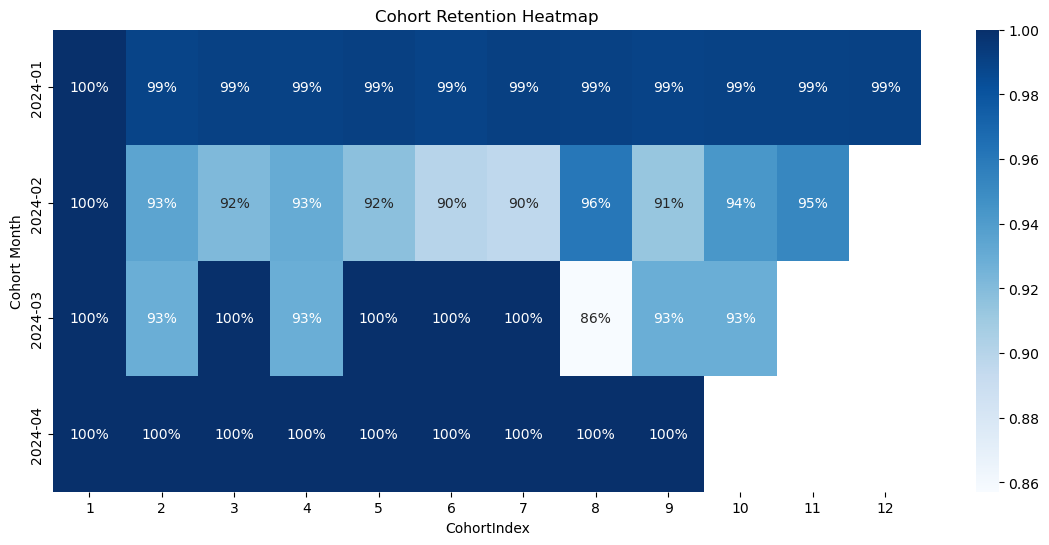

In [14]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    new_cohort_table,
    annot=True,
    fmt=".0%",       # show as percentages (no decimals)
    cmap="Blues"
)
plt.xlabel("CohortIndex")
plt.ylabel("Cohort Month")
plt.title("Cohort Retention Heatmap")
plt.show()